In [236]:
import pynq
import time
from pynq import Overlay
from pynq.lib.video import *
overlay = Overlay("design_1_wrapper.bit")
overlay.is_loaded()
resnet = overlay.resnet_0
import struct
# import pynq
# import time
# from pynq import Overlay
# import os
# import struct
# import numpy as np
# from pynq import allocate
# import cv2
# from matplotlib import pyplot as plt
# import subprocess

In [237]:
import numpy as np
from pynq import allocate
import cv2
from matplotlib import pyplot as plt
import platform
# 初始化 PYNQ
# overlay = Overlay("design_1_wrapper.bit")
# overlay.is_loaded()
# resnet = overlay.resnet_0

In [238]:
def RunResnet(lenet, img_in, cout):
    lenet.write(0x10, img_in.physical_address)
    lenet.write(0x1c, cout.physical_address)
    lenet.write(0, (lenet.read(0)&0x80|0x01))
    tp = lenet.read(0)
    while not ((tp>>1)&0x1):
        tp=lenet.read(0)


In [239]:
# # get .h files
# img_dir = "./img"
# h_files = [f for f in os.listdir(img_dir) if f.endswith('.h')]

img_in = allocate(shape=(49152), dtype=np.float16)
cout = allocate(shape=(2), dtype=np.float16)

In [240]:
# # time and power cosume
# total_time = 0.0
# total_power = 0.0
# num_files = len(h_files)

Frame read successfully


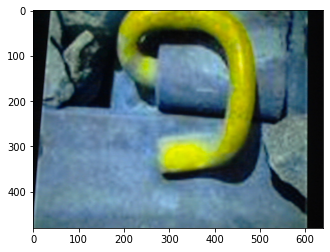

Frame shape: (480, 640, 3)
Saved


In [242]:
cap = cv2.VideoCapture(0)
# width = 28
# height = 28
# cap.set(cv2.CAP_PROP_FRAME_WIDTH, width)
# cap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
ret, frame = cap.read()
if not ret:
    print("Failed to read frame")
else:
    print("Frame read successfully")
    plt.imshow(frame)
    plt.show()
    # cv2.imwrite('cap-origin.bmp', frame)
    # set resize
    print("Frame shape:", frame.shape)
    # scale = 0.5

#     # calc new resize
#     new_width = int(frame.shape[1] * (7/160))
#     new_height = int(frame.shape[0] * (7/120))

#     # resize
#     resized_image = cv2.resize(frame, (new_width, new_height))

#     # show the resized img
#     print("Frame shape changed to:", resized_image.shape)
#     plt.imshow(resized_image, extent=(0, new_width, 0, new_height))
#     plt.show()
    cv2.imwrite('cap.jpg', frame)
    print("Saved")

cap.release()

In [243]:
from PIL import Image
import torchvision.transforms as transforms
import numpy as np

# define preprocess of data
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4315, 0.3989, 0.3650], [0.2250, 0.2176, 0.2111])
])

# covert to RGB
# image_path = "./Test/Defective/defective (9).jpg"
image_path = "./cap.jpg"
img = Image.open(image_path).convert('RGB')

# make sure size 128x128
img = img.resize((128, 128))

# preprocess
img_tensor = data_transform(img)

# covert to numpy float32
img_array = img_tensor.numpy().astype(np.float32)

flattened_image = img_array.flatten()
# copy flattened_image to img_in
np.copyto(img_in, flattened_image)

print(img_in)
print("finish converting image to float format")


[-1.778 -1.761 -1.743 ... -1.617 -1.617 -1.636]
finish converting image to float format


In [245]:
start_time = time.process_time()
RunResnet(resnet, img_in, cout)

end_time = time.process_time()
elapsed_time = end_time - start_time
print("Hardware run finish in {:.5f} seconds".format(elapsed_time))
print("Defective:", cout[0])
print("Non defective:", cout[1])


Hardware run finish in 0.68368 seconds
Defective: 0.2031
Non defective: 0.789


In [ ]:
if (cout[0] > cout[1]):
    # send the location from esp8266
    ser = serial.Serial('/dev/ttyUSB0', 115200, timeout=1)
    ser.flush()
    ser.write(b'sendLocation')
    ser.close()
    print("Correct!")